<a href="https://colab.research.google.com/github/hyjucl/02_us/blob/main/cw3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the necessary libraries 
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [ ]:
# Read in the edgelist file from csv
cdata = pd.read_csv("london_flows.csv")

# Print data (first five rows)
cdata.head()

,station_origin,station_destination,flows,population,jobs,distance,pop,ori_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,29494,345
1,Abbey Road,Beckton,1,599,442,8510.121774,1179,345
2,Abbey Road,Blackwall,3,599,665,3775.448872,952,345
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,14632,345
4,Abbey Road,Canning Town,37,599,15428,2228.923167,21125,345


In [ ]:
cdata = cdata.drop(cdata[cdata['jobs'] == 0].index)
cdata = cdata.drop(cdata[cdata['flows'] == 0].index)
cdata = cdata.drop(cdata[cdata['population'] == 0].index)

# III.2. Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter beta. Make sure to justify your selection of model.

In [ ]:
#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
cdata["TotalNoIntra"] = cdata.apply(lambda x: 0 if x['station_origin'] == x['station_destination'] else x['flows'], axis=1)

In [ ]:
cdata["offset"]= cdata.apply(lambda x: 0.0000000001 if x['station_origin'] == x['station_destination'] else 0, axis=1)

In [ ]:
#look at the flows that originate from the city of London
cdata.head(33)

,station_origin,station_destination,flows,population,jobs,distance,pop,ori_jobs,TotalNoIntra,offset
1,Abbey Road,Beckton,1,599,442,8510.121774,1179,345,1,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,952,345,3,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,14632,345,1,0.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,21125,345,37,0.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1724,345,1,0.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2122,345,2,0.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,500,345,7,0.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,1387,345,1,0.0
10,Abbey Road,East India,2,599,1522,3384.141666,1760,345,2,0.0
11,Abbey Road,Island Gardens,2,599,691,7706.296370,1413,345,2,0.0


In [ ]:
import numpy as np
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(cdata, values="TotalNoIntra", index="station_origin", columns ="station_destination",
                              aggfunc=np.sum, margins=True)
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


Text(0, 0.5, 'Total Flows')

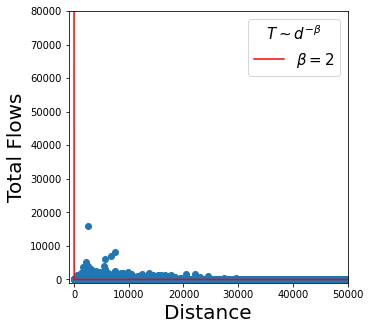

In [ ]:
#first plot the Total commuter flows denoted by T against distance denoted by d
#and then fit a model line T ~ d^-beta with beta=2

#set the base axis
fig, ax = plt.subplots(figsize=(5,5))

#scatter plot
ax.scatter(x = cdata["distance"], y=cdata["flows"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
#add a legend
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-1000,50000])
ax.set_ylim([-1000, 80000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Text(0, 0.5, 'Total Flows')

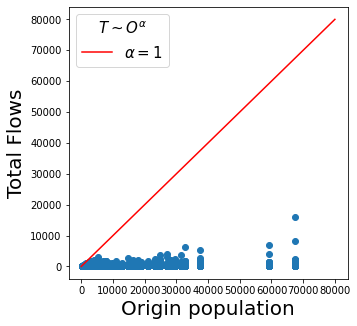

In [ ]:
#Let us now look at the behaviour of the flows with respect to the population at the origin denoted by O
#and then fit a model line T ~ O^alpha, for alpha=1

#set the base axis
fig, ax = plt.subplots(figsize=(5,5))

#scatter plot
ax.scatter(x = cdata["population"], y=cdata["flows"])
#line plot
line = np.arange(0.0002, 80000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\alpha=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Text(0, 0.5, 'Total')

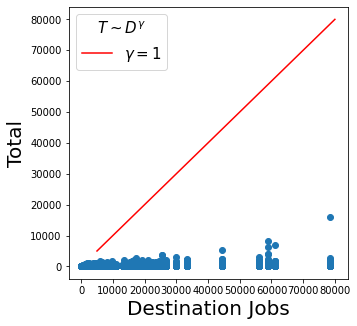

In [ ]:
#Now let us look at the behaviour of the flows with respect to the salaries at destination denoted by D
# and then fit a model line  T ~ D^gamma. We will fit a line for gamma=1

#set the base axis
fig, ax = plt.subplots(figsize=(5,5))

#scatter plot
ax.scatter(x = cdata["jobs"], y=cdata["flows"])
#line plot
line = np.arange(5000, 80000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\gamma=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Destination Jobs", fontsize = 20)
ax.set_ylabel("Total", fontsize = 20)

In [ ]:
#set up some variables to hold our parameter values in:
alpha = 1
gamma = 1
beta = 2
k = 1
T2 = sum(cdata["flows"])

In [ ]:
Oi1_alpha = cdata["population"]**alpha
Dj2_gamma = cdata["jobs"]**gamma
dist_beta = cdata["distance"]**-beta
T1 = Oi1_alpha*Dj2_gamma*dist_beta

In [ ]:
# from numpy import inf
# T1[T1 == -inf] = 0.0000000000001

In [ ]:
T1

1        0.003656
2        0.027945
3        1.360682
4        1.860143
5        0.016184
           ...   
61469    0.146848
61470    0.571924
61471    0.034710
61472    0.245742
61473    0.099476
Length: 43952, dtype: float64

In [ ]:
T1 = T1.replace(np.inf, np.nan)
#T1 = T1.replace(np.inf, 0.0000000000001)

In [ ]:
T1 = T1.dropna()

In [ ]:
k = T2/sum(T1)

In [ ]:
k

13.649055082620034

In [ ]:
#run the model and store of the new flow estimates in a new column
cdata["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)

In [ ]:
cdata = cdata.replace(np.inf, np.nan)
#cdata1 = cdata1.replace(np.inf, 0.0000000000001)
cdata = cdata.dropna()
#convert to integers
cdata["unconstrainedEst1"] = cdata["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdata["unconstrainedEst1"])
#check 下面有一个matrix 右下角的total应该和这个数值一样

1540323

In [ ]:
cdatasubmat1 = cdata.pivot_table(values ="unconstrainedEst1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,559
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
Acton Town,NaN,NaN,NaN,1.0,1.0,NaN,2.0,NaN,NaN,2.0,...,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,596
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,9752
Aldgate East,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,...,1.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,7908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,2.0,3.0,NaN,NaN,NaN,NaN,2.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,329
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
Woodside Park,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216


In [ ]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [ ]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

CalcRSqaured(cdata["flows"], cdata["unconstrainedEst1"])

0.033816925145303

In [ ]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

CalcRMSE(cdata["flows"], cdata["unconstrainedEst1"])

582.023

## possion regression model

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    cdata[f"log_{x}"] = np.log(cdata[x])
    log_x_vars.append(f"log_{x}")

#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'

In [ ]:
# cdata1 = cdata.replace([np.inf, -np.inf], np.nan)
#cdata = cdata.replace([np.inf, -np.inf], 0.0000000000001)

In [ ]:
# cdata = cdata.dropna()

In [ ]:
#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdata, 
                  family=sm.families.Poisson()).fit()

In [ ]:
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43941
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1675e+06
Date:                Mon, 02 May 2022   Deviance:                   2.1627e+06
Time:                        21:16:12   Pearson chi2:                 4.13e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0646      0.014   -223.

In [ ]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
cdata["unconstrainedEst2"] = np.exp(K 
                                       + alpha*cdata["log_population"] 
                                       + gamma*cdata["log_jobs"] 
                                       - beta*cdata["log_distance"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdata["fitted"] = predictions_summary_frame["mean"]

In [ ]:
uncosim.mu

array([ 1.33185192,  2.88212504, 56.51864263, ...,  7.0022738 ,
       17.38163883, 15.21476603])

In [ ]:
beta

0.596147305476278

In [ ]:
#round the numbers so that we don't get a half of a person
cdata["unconstrainedEst2"] = round(cdata["unconstrainedEst2"], 0)
#convert to integers
cdata["unconstrainedEst2"] = cdata["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(cdata["unconstrainedEst2"])

1542307

In [ ]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat2 = cdata.pivot_table(values ="unconstrainedEst2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,371
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,9.0,NaN,NaN,26.0,...,22.0,4.0,8.0,14.0,NaN,NaN,NaN,NaN,NaN,4045
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,...,NaN,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,5381
Aldgate East,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,...,17.0,NaN,NaN,8.0,NaN,4.0,NaN,4.0,NaN,6288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,30.0,32.0,NaN,NaN,NaN,NaN,28.0,...,16.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,3943
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54
Woodside Park,NaN,NaN,7.0,21.0,21.0,NaN,NaN,NaN,NaN,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2848


In [ ]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [ ]:
CalcRSqaured(cdata["flows"], cdata["unconstrainedEst2"])

0.311415595917023

In [ ]:
CalcRMSE(cdata["flows"], cdata["unconstrainedEst2"])

128.175

In [ ]:
def model_predict(dataframe, formula):
    
    #run a model
    model = smf.glm(formula, data = dataframe, family = sm.families.Poisson()).fit()
    #print(model.summary())
    predictions = model.get_prediction()
    predictions_summary_frame = predictions.summary_frame()
    
    dataframe[formula] = predictions_summary_frame["mean"]
    
    # round and covert to int
    dataframe[formula] = round(dataframe[formula],0)
    dataframe[formula] = dataframe[formula].astype(int)
    
    # Show the result as a pivot table

    # pivot_table = dataframe.pivot_table(values = formula, index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
    
    # print(pivot_table)
    
    #Calculate the matric
    beta_pre = model.params[-1]
    Rsq = CalcRSqaured(cdata["flows"],cdata[formula])
    RMSE = CalcRMSE(cdata["flows"],cdata[formula])
    
    return (sum(dataframe[formula]), Rsq, RMSE, beta_pre)
#    return (sum(dataframe[formula]), Rsq, RMSE, model.summary()) 

In [ ]:
pivot_actual = pd.pivot_table(cdata, values="flows", index="station_origin", columns ="station_destination",
                              aggfunc=np.sum, margins=True)
#pivot _actual.to_csv/"output/pivot_actual.csv")

In [ ]:
# Define list of formulas
formula_list = [
    'flows ~ log_population + log_jobs + log_distance', # unconstrained power
    'flows ~ log_population * log_jobs + distance', # unconstrained exponential
    'flows ~ station_origin + log_jobs + log_distance-1', # production constrained power
    'flows ~ station_origin + log_jobs + distance-1', # production constrained exponential
    'flows ~ station_destination + log_population + log_distance-1', # attraction constrained power
    'flows ~ station_destination + log_population + distance-1', # attraction constrained exponential
    'flows ~ station_destination + station_origin + log_distance-1', # doubly constrained power
    'flows ~ station_destination + station_origin + distance-1' # doubly constrained exponential
]

In [ ]:
# Run the model-> output: (total, R2, RSME)+ parameters
for formula in formula_list:
    print (model_predict(cdata, formula))

(1542307, 0.311415595917023, 128.175, -0.596147305476278)
(1542305, 0.39198789853008437, 120.978, -8.328715604639578e-05)
(1542315, 0.3937259232863417, 120.147, -0.8151874614763797)
(1542186, 0.4645138060258822, 113.556, -0.00014373298489287782)
(1542279, 0.34823921191707785, 124.587, -0.6065002372495777)
(1542287, 0.39510908778698817, 120.597, -9.389959102200802e-05)
(1542274, 0.41893772760573444, 117.622, -0.8473602005706751)
(1542263, 0.4997778698538132, 109.598, -0.00014481467725336483)


In [ ]:
# strategy A result
m_p = {       'models':['unconstrained power',
                 'unconstrained exp',
                 'production constrained power',
                 'production constrained exp',
                 'attraction constrained power',
                 'attraction constrained exp',
                 'doubly constrained power',
                 'doubly constrained exp'],
       'R2':[0.311415595917023,0.39198789853008437,0.3937259232863417,0.4645138060258822,0.34823921191707785,0.39510908778698817,0.41893772760573444,0.4997778698538132],
        'RSME':[128.175,120.978,120.147,113.556,124.587,120.597,117.622,109.598],
        'beta':[0.596147305476278,0.00008328715604600001,0.8151874614763797,0.00014373298489287782,0.6065002372495777,0.00009389959102199999,0.8473602005706751,0.00014481467725336483],
       'total_flow':[1542307,1542305,1542315,1542186,1542279,1542287,1542274,1542263]
}


m_p = pd.DataFrame.from_dict(m_p)
m_p = m_p.set_index(['models'])
m_p

,R2,RSME,beta,total_flow
models,,,,
unconstrained power,0.311416,128.175,0.596147,1542307
unconstrained exp,0.391988,120.978,0.000083,1542305
production constrained power,0.393726,120.147,0.815187,1542315
production constrained exp,0.464514,113.556,0.000144,1542186
attraction constrained power,0.348239,124.587,0.606500,1542279
attraction constrained exp,0.395109,120.597,0.000094,1542287
doubly constrained power,0.418938,117.622,0.847360,1542274
doubly constrained exp,0.499778,109.598,0.000145,1542263


In [ ]:
#set out all the fomrulas
formula1 = "flows ~ log_population + log_jobs + log_distance -1"
formula2 = "flows ~ station_origin + log_jobs + log_distance -1"
formula3 = "flows ~ station_destination + log_population + log_distance-1"
formula4 = "flows ~ station_destination + station_origin + log_distance-1"
formula5 = "flows ~ log_population * log_jobs + distance -1"
formula6 = "flows ~ station_origin + log_jobs + distance-1"
formula7 = "flows ~ station_destination + log_population + distance-1"
formula8 = "flows ~ station_destination + station_origin + distance-1"


#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncosim_pow", "prodsim_pow", "attrsim_pow", "doublesim_pow",
         "uncosim_exp", "prodsim_exp", "attrsim_exp", "doublesim_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}

#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = cdata,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    cdata[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to the results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSqaured(cdata["flows"],cdata[models[i]]))
    results["RMSE"].append(CalcRMSE(cdata["flows"],cdata[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results

,Model,R2,RMSE,Alpha,Gamma,Beta
0,uncosim_pow,0.251408,133.501,0.599264,0.612741,-0.749470
1,prodsim_pow,0.393730,120.146,NaN,0.730170,-0.815187
2,attrsim_pow,0.348251,124.586,0.715607,NaN,-0.606500
3,doublesim_pow,0.418926,117.623,NaN,NaN,-0.847360
4,uncosim_exp,0.384678,121.798,-0.089447,0.087705,-0.000084
5,prodsim_exp,0.464517,113.556,NaN,0.725617,-0.000144
6,attrsim_exp,0.395106,120.597,0.688217,NaN,-0.000094
7,doublesim_exp,0.499812,109.594,NaN,NaN,-0.000145


# IV Scenario: 

## IV.1 Scenario A: 

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
# OrigCodeNew is dummy variable as alpha_i

formula = 'flows ~ station_origin + log_jobs + log_distance-1'   # final flow difference is 163
#formula = 'flows ~ station_origin + log_jobs + distance-1'         # final flow difference is 18
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdata, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43545
Model Family:                 Poisson   Df Model:                          399
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1409e+05
Date:                Mon, 02 May 2022   Deviance:                   1.6560e+06
Time:                        21:21:56   Pearson chi2:                 2.41e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

the $\gamma$  parameter related to the destination attractiveness: 0.7302

The $\beta$  distance decay parameter: 0.8152. Recall the negative sign in the equation.

In [ ]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdata.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdata = cdata.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdata.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdata = cdata.merge(D_j, on = "station_destination", how = "left" )

In [ ]:
cdata.head()

,station_origin,station_destination,flows,population,jobs,distance,pop,ori_jobs,TotalNoIntra,offset,...,uncosim_pow,prodsim_pow,attrsim_pow,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j
0,Abbey Road,Beckton,1,599,442,8510.121774,1179,345,1,0.0,...,2.187787,1.406918,4.338397,3.155354,3.537041,2.023660,4.963744,4.338910,599,442
1,Abbey Road,Blackwall,3,599,665,3775.448872,952,345,3,0.0,...,5.167056,3.677350,4.230828,3.306465,6.368819,5.375408,5.144218,4.376505,599,665
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,14632,345,1,0.0,...,64.391949,76.062924,75.993812,84.074049,47.217012,115.047249,99.980157,127.407043,599,58772
3,Abbey Road,Canning Town,37,599,15428,2228.923167,21125,345,37,0.0,...,52.658433,56.123931,36.891409,48.854668,31.910271,65.731157,38.922249,54.162722,599,15428
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1724,345,1,0.0,...,4.853484,3.568414,6.114094,4.030917,6.617017,5.455203,7.820382,5.836399,599,1208


In [ ]:
#We can do this by pulling out the parameter values
# clean the format of coefs
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdata = cdata.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdata.drop(columns = ["coef"], inplace = True)
#check this has worked
cdata.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,station_origin,station_destination,flows,population,jobs,distance,pop,ori_jobs,TotalNoIntra,offset,...,prodsim_pow,attrsim_pow,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,alpha_i
0,Abbey Road,Beckton,1,599,442,8510.121774,1179,345,1,0.0,...,1.406918,4.338397,3.155354,3.537041,2.023660,4.963744,4.338910,599,442,3.270351
1,Abbey Road,Blackwall,3,599,665,3775.448872,952,345,3,0.0,...,3.677350,4.230828,3.306465,6.368819,5.375408,5.144218,4.376505,599,665,3.270351
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,14632,345,1,0.0,...,76.062924,75.993812,84.074049,47.217012,115.047249,99.980157,127.407043,599,58772,3.270351
3,Abbey Road,Canning Town,37,599,15428,2228.923167,21125,345,37,0.0,...,56.123931,36.891409,48.854668,31.910271,65.731157,38.922249,54.162722,599,15428,3.270351
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1724,345,1,0.0,...,3.568414,6.114094,4.030917,6.617017,5.455203,7.820382,5.836399,599,1208,3.270351


In [ ]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [ ]:
print(alpha_i)
print("gamma" + str(gamma))
print("beta:" + str(beta))

station_origin[Abbey Road]          3.270351
station_origin[Acton Central]       5.008886
station_origin[Acton Town]          4.397394
station_origin[Aldgate]             3.361125
station_origin[Aldgate East]        3.408728
                                      ...   
station_origin[Wood Street]         5.672160
station_origin[Woodford]            4.955425
station_origin[Woodgrange Park]     5.320215
station_origin[Woodside Park]       4.496709
station_origin[Woolwich Arsenal]    6.701868
Length: 398, dtype: float64
gamma0.7301699265801939
beta:0.8151874614763797


In [ ]:
cdata["prodsimest1"] = np.exp(cdata["alpha_i"]+gamma*cdata["log_jobs"] 
                                 - beta*cdata["log_distance"])

In [ ]:
# cdata["prodsimest1"] = np.exp(cdata["alpha_i"]+gamma*cdata["log_jobs"] 
#                                  - beta*cdata["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdata.head(10)

,station_origin,station_destination,flows,population,jobs,distance,pop,ori_jobs,TotalNoIntra,offset,...,attrsim_pow,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,1179,345,1,0.0,...,4.338397,3.155354,3.537041,2.023660,4.963744,4.338910,599,442,3.270351,1.406918
1,Abbey Road,Blackwall,3,599,665,3775.448872,952,345,3,0.0,...,4.230828,3.306465,6.368819,5.375408,5.144218,4.376505,599,665,3.270351,3.677350
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,14632,345,1,0.0,...,75.993812,84.074049,47.217012,115.047249,99.980157,127.407043,599,58772,3.270351,76.062924
3,Abbey Road,Canning Town,37,599,15428,2228.923167,21125,345,37,0.0,...,36.891409,48.854668,31.910271,65.731157,38.922249,54.162722,599,15428,3.270351,56.123931
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1724,345,1,0.0,...,6.114094,4.030917,6.617017,5.455203,7.820382,5.836399,599,1208,3.270351,3.568414
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2122,345,2,0.0,...,9.023814,5.505967,6.766720,5.492955,10.752272,7.660433,599,1748,3.270351,3.841726
6,Abbey Road,Cyprus,7,599,850,6532.099618,500,345,7,0.0,...,6.585355,4.827610,5.679333,4.321986,7.554172,6.476352,599,850,3.270351,2.813752
7,Abbey Road,Devons Road,1,599,611,3958.324171,1387,345,1,0.0,...,4.375389,3.335744,6.026757,4.923879,5.104278,4.411670,599,611,3.270351,3.326081
8,Abbey Road,East India,2,599,1522,3384.141666,1760,345,2,0.0,...,9.912539,7.882652,9.722697,10.369665,11.527970,9.984373,599,1522,3.270351,7.359304
9,Abbey Road,Island Gardens,2,599,691,7706.296370,1413,345,2,0.0,...,3.767756,2.407495,4.669736,3.141409,4.676604,3.424519,599,691,3.270351,2.113923


In [ ]:
#first round the estimates
cdata["prodsimest1"] = round(cdata["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat3 = cdata.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,20.0,20.0,NaN,10.0,NaN,NaN,22.0,...,18.0,4.0,6.0,14.0,NaN,NaN,NaN,NaN,NaN,3750.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2889.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,6.0,NaN,NaN,3.0,NaN,1.0,NaN,1.0,NaN,3176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,37.0,41.0,NaN,NaN,NaN,NaN,34.0,...,17.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4870.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,6.0,22.0,22.0,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [ ]:
CalcRSquared(cdata["flows"], cdata["prodsimest1"])

0.3937259232863417

### what if 
assume that Canary Wharf has a 50% decrease in jobs after Brexit. 

In [ ]:
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = 58772*0.5
    else:
        val = row["jobs"]
    return val
        
cdata["jobs_re"] = cdata.apply(new_jobs, axis =1)
cdata["jobs_re"] = cdata["jobs_re"].astype(int)
cdata.head(10)

,station_origin,station_destination,flows,population,jobs,distance,pop,ori_jobs,TotalNoIntra,offset,...,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,alpha_i,prodsimest1,jobs_re
0,Abbey Road,Beckton,1,599,442,8510.121774,1179,345,1,0.0,...,3.155354,3.537041,2.023660,4.963744,4.338910,599,442,3.270351,1.0,442
1,Abbey Road,Blackwall,3,599,665,3775.448872,952,345,3,0.0,...,3.306465,6.368819,5.375408,5.144218,4.376505,599,665,3.270351,4.0,665
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,14632,345,1,0.0,...,84.074049,47.217012,115.047249,99.980157,127.407043,599,58772,3.270351,76.0,29386
3,Abbey Road,Canning Town,37,599,15428,2228.923167,21125,345,37,0.0,...,48.854668,31.910271,65.731157,38.922249,54.162722,599,15428,3.270351,56.0,15428
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1724,345,1,0.0,...,4.030917,6.617017,5.455203,7.820382,5.836399,599,1208,3.270351,4.0,1208
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2122,345,2,0.0,...,5.505967,6.766720,5.492955,10.752272,7.660433,599,1748,3.270351,4.0,1748
6,Abbey Road,Cyprus,7,599,850,6532.099618,500,345,7,0.0,...,4.827610,5.679333,4.321986,7.554172,6.476352,599,850,3.270351,3.0,850
7,Abbey Road,Devons Road,1,599,611,3958.324171,1387,345,1,0.0,...,3.335744,6.026757,4.923879,5.104278,4.411670,599,611,3.270351,3.0,611
8,Abbey Road,East India,2,599,1522,3384.141666,1760,345,2,0.0,...,7.882652,9.722697,10.369665,11.527970,9.984373,599,1522,3.270351,7.0,1522
9,Abbey Road,Island Gardens,2,599,691,7706.296370,1413,345,2,0.0,...,2.407495,4.669736,3.141409,4.676604,3.424519,599,691,3.270351,2.0,691


In [ ]:
cdata["prodsimest2"] = np.exp(cdata["alpha_i"]+gamma*np.log(cdata["jobs_re"]) - beta*cdata["log_distance"])

cdata["prodsimest2"] = round(cdata["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat4 = cdata.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,571.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,20.0,20.0,NaN,10.0,NaN,NaN,22.0,...,18.0,4.0,6.0,14.0,NaN,NaN,NaN,NaN,NaN,3720.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2862.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,6.0,NaN,NaN,3.0,NaN,1.0,NaN,1.0,NaN,3141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,37.0,41.0,NaN,NaN,NaN,NaN,34.0,...,17.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4799.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,6.0,22.0,22.0,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3061.0


In [ ]:
CalcRSquared(cdata["flows"], cdata["prodsimest2"])

0.379573729059288

In [ ]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [ ]:
#calculate some new wj^alpha and d_ij^beta values
#在计算equation3
Dj2_gamma = cdata["jobs"]**gamma
dist_beta = cdata["distance"]** -beta ##注意符号
#calcualte the first stage of the Ai values
cdata["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdata.groupby(["station_origin"])["Ai1"].agg(np.sum)) #上面那个ai的公式的sum边上是j 但按照origin来sum 如果是i 就按照distention来sum
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdata = cdata.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [ ]:
cdata[['station_origin','A_i']].sample(5)

,station_origin,A_i
29665,Putney Bridge,0.018179
32339,Shepherd's Bush Market,0.020422
18441,Highgate,0.019425
39893,Warren Street,0.008827
33893,Southfields,0.021901


In [ ]:
#to check everything works, recreate the original estimates
cdata["prodsimest3"] = cdata["A_i"]*cdata["O_i"]*Dj2_gamma*dist_beta
#round
cdata["prodsimest3"] = round(cdata["prodsimest3"])
#check
cdata[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,1.0,1.0
1,4.0,4.0
2,76.0,76.0
3,56.0,56.0
4,4.0,4.0
...,...,...
43940,132.0,132.0
43941,269.0,269.0
43942,37.0,37.0
43943,106.0,106.0


In [ ]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdata["jobs_re"]**gamma
#calcualte the first stage of the Ai values
cdata["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdata.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdata = cdata.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [ ]:
cdata[['station_origin','A_i','A_i2']].sample(5)

,station_origin,A_i,A_i2
42344,Westminster,0.008749,0.008809
33022,South Harrow,0.040189,0.040629
21922,Lambeth North,0.009322,0.009391
38590,Upton Park,0.019531,0.019883
43018,Willesden Junction,0.020036,0.020197


In [ ]:
#to check everything works, recreate the original estimates
cdata["prodsimest4"] = cdata["A_i2"]*cdata["O_i"]*Dj3_gamma*dist_beta
#round
cdata["prodsimest4"] = round(cdata["prodsimest4"])

In [ ]:
cdatasubmat5 = cdata.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,20.0,20.0,NaN,10.0,NaN,NaN,22.0,...,18.0,4.0,6.0,14.0,NaN,NaN,NaN,NaN,NaN,3746.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,...,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2886.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,...,6.0,NaN,NaN,3.0,NaN,2.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,38.0,41.0,NaN,NaN,NaN,NaN,35.0,...,17.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,6.0,22.0,22.0,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [ ]:
CalcRSquared(cdata["flows"], cdata["prodsimest4"])

0.37953741803436225

In [ ]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [ ]:
#plot for the SA
diff_pd = cdata.groupby('station_destination',as_index=False).agg({'prodsimest1':'sum','prodsimest4':'sum'})

diff_pd["diff_abs"]= abs(diff_pd["prodsimest4"] - diff_pd["prodsimest1"])
diff_pd["diff"]= diff_pd["prodsimest4"] - diff_pd["prodsimest1"]
diff_pd.sort_values(by=["diff_abs"],ascending= False, inplace = True)
diff_pd_50 = diff_pd.head(50)
diff_pd_50

,station_destination,prodsimest1,prodsimest4,diff_abs,diff
54,Canary Wharf,49645.0,31421.0,18224.0,-18224.0
15,Bank and Monument,69789.0,71349.0,1560.0,1560.0
326,Stratford,60765.0,61950.0,1185.0,1185.0
55,Canning Town,16917.0,17581.0,664.0,664.0
212,Liverpool Street,62919.0,63362.0,443.0,443.0
251,Oxford Circus,37564.0,37913.0,349.0,349.0
163,Heron Quays,4403.0,4711.0,308.0,308.0
213,London Bridge,27819.0,28110.0,291.0,291.0
291,Shadwell,7964.0,8253.0,289.0,289.0
197,King's Cross St. Pancras,29180.0,29454.0,274.0,274.0


In [ ]:
diff_pd_ori = cdata.groupby('station_origin',as_index=False).agg({'flows':'sum','prodsimest4':'sum'})
diff_pd_ori.loc[diff_pd_ori['station_origin'] == 'Canary Wharf']

,station_origin,flows,prodsimest4
54,Canary Wharf,14632,14625.0


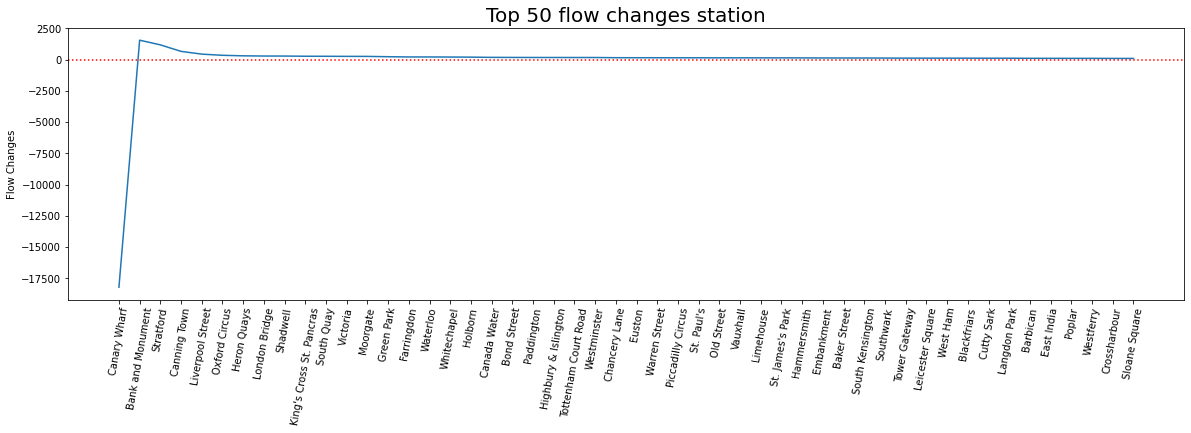

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = diff_pd_50['station_destination']
y = diff_pd_50['diff']

# plot line
plt.figure(figsize = (20,5))
plt.axhline(y=0, color='red', linestyle='dotted')
plt.xticks(rotation=80)
plt.ylabel('Flow Changes')
plt.title('Top 50 flow changes station', fontsize=20)
plt.plot(x, y)
plt.savefig('PRO_flow', figsize=(20,10))
plt.show()


## IV.2. Scenario B

## Beta x 2

In [ ]:
beta = -prodSim.params[399]
beta_1 = beta*2

Dj4_gamma = cdata["jobs"]**gamma
dist_beta = cdata["distance"]** -beta_1 ##注意符号
cdata["Ai1"] = Dj4_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdata.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
cdata = cdata.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [ ]:
#to check everything works, recreate the original estimates
cdata["prodsimest5"] = cdata["A_i3"]*cdata["O_i"]*Dj2_gamma*dist_beta
#round
cdata["prodsimest5"] = round(cdata["prodsimest5"])


## Beta x 3

In [ ]:
beta = -prodSim.params[399]
beta_2 = beta*3

Dj5_gamma = cdata["jobs"]**gamma
dist_beta = cdata["distance"]** -beta_2 ##注意符号
cdata["Ai1"] = Dj5_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdata.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
cdata = cdata.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [ ]:
#to check everything works, recreate the original estimates
cdata["prodsimest6"] = cdata["A_i4"]*cdata["O_i"]*Dj2_gamma*dist_beta
#round
cdata["prodsimest6"] = round(cdata["prodsimest6"])

In [182]:
#plot for the SA
diff_pdb = cdata.groupby('station_destination',as_index=False).agg({'prodsimest1':'sum','prodsimest5':'sum','prodsimest6':'sum'})
diff_pdb.sort_values(by=["prodsimest1"],ascending= False, inplace = True)

diff_pdb["diff_abs"]= abs(diff_pdb["prodsimest5"] - diff_pdb["prodsimest1"])
#diff_pdb["diff_abs2"]= abs(diff_pdb["prodsimest6"] - diff_pdb["prodsimest1"])
diff_pdb["diff_"]= diff_pdb["prodsimest5"] - diff_pdb["prodsimest1"]
#diff_pdb["diff_2"]= diff_pdb["prodsimest6"] - diff_pdb["prodsimest1"]
diff_pdb.sort_values(by=["diff_abs"],ascending= False, inplace = True)


#diff_pdb
diff_pdb_50 = diff_pdb.head(50)
diff_pdb_50

,station_destination,prodsimest1,prodsimest5,prodsimest6,diff_abs,diff_
326,Stratford,60765.0,51002.0,39891.0,9763.0,-9763.0
212,Liverpool Street,62919.0,53411.0,37044.0,9508.0,-9508.0
54,Canary Wharf,49645.0,44421.0,33773.0,5224.0,-5224.0
227,Moorgate,25997.0,30754.0,31687.0,4757.0,4757.0
327,Stratford High Street,1071.0,5479.0,20125.0,4408.0,4408.0
163,Heron Quays,4403.0,8588.0,12254.0,4185.0,4185.0
119,Farringdon,22893.0,19443.0,11779.0,3450.0,-3450.0
386,Whitechapel,22307.0,19066.0,13467.0,3241.0,-3241.0
355,Victoria,27746.0,24704.0,17168.0,3042.0,-3042.0
313,Southwark,13562.0,16582.0,19655.0,3020.0,3020.0


In [ ]:
#plot for the SA
diff_pdb2 = cdata.groupby('station_destination',as_index=False).agg({'prodsimest1':'sum','prodsimest6':'sum'})
diff_pdb2.sort_values(by=["prodsimest1"],ascending= False, inplace = True)

diff_pdb2["diff_abs"]= abs(diff_pdb2["prodsimest6"] - diff_pdb2["prodsimest1"])
diff_pdb2["diff"]= diff_pdb2["prodsimest6"] - diff_pdb2["prodsimest1"]
diff_pdb2.sort_values(by=["diff_abs"],ascending= False, inplace = True)


#diff_pdb
diff_2pdb_50 = diff_pdb2.head(50)
diff_2pdb_50

,station_destination,prodsimest1,prodsimest6,diff_abs,diff
212,Liverpool Street,62919.0,37044.0,25875.0,-25875.0
326,Stratford,60765.0,39891.0,20874.0,-20874.0
327,Stratford High Street,1071.0,20125.0,19054.0,19054.0
54,Canary Wharf,49645.0,33773.0,15872.0,-15872.0
251,Oxford Circus,37564.0,23097.0,14467.0,-14467.0
15,Bank and Monument,69789.0,55996.0,13793.0,-13793.0
119,Farringdon,22893.0,11779.0,11114.0,-11114.0
355,Victoria,27746.0,17168.0,10578.0,-10578.0
170,Holborn,22609.0,13231.0,9378.0,-9378.0
386,Whitechapel,22307.0,13467.0,8840.0,-8840.0


In [ ]:
diff_pdb.sort_values(by=["diff_abs1"],ascending= False, inplace = True)


#diff_pdb
diff_pdb_51 = diff_pdb.head(50)
diff_pdb_51

,station_destination,prodsimest1,prodsimest5,prodsimest6,diff_abs1,diff_abs2,diff_1,diff_2
326,Stratford,60765.0,51002.0,39891.0,9763.0,20874.0,-9763.0,-20874.0
212,Liverpool Street,62919.0,53411.0,37044.0,9508.0,25875.0,-9508.0,-25875.0
54,Canary Wharf,49645.0,44421.0,33773.0,5224.0,15872.0,-5224.0,-15872.0
227,Moorgate,25997.0,30754.0,31687.0,4757.0,5690.0,4757.0,5690.0
327,Stratford High Street,1071.0,5479.0,20125.0,4408.0,19054.0,4408.0,19054.0
163,Heron Quays,4403.0,8588.0,12254.0,4185.0,7851.0,4185.0,7851.0
119,Farringdon,22893.0,19443.0,11779.0,3450.0,11114.0,-3450.0,-11114.0
386,Whitechapel,22307.0,19066.0,13467.0,3241.0,8840.0,-3241.0,-8840.0
355,Victoria,27746.0,24704.0,17168.0,3042.0,10578.0,-3042.0,-10578.0
313,Southwark,13562.0,16582.0,19655.0,3020.0,6093.0,3020.0,6093.0


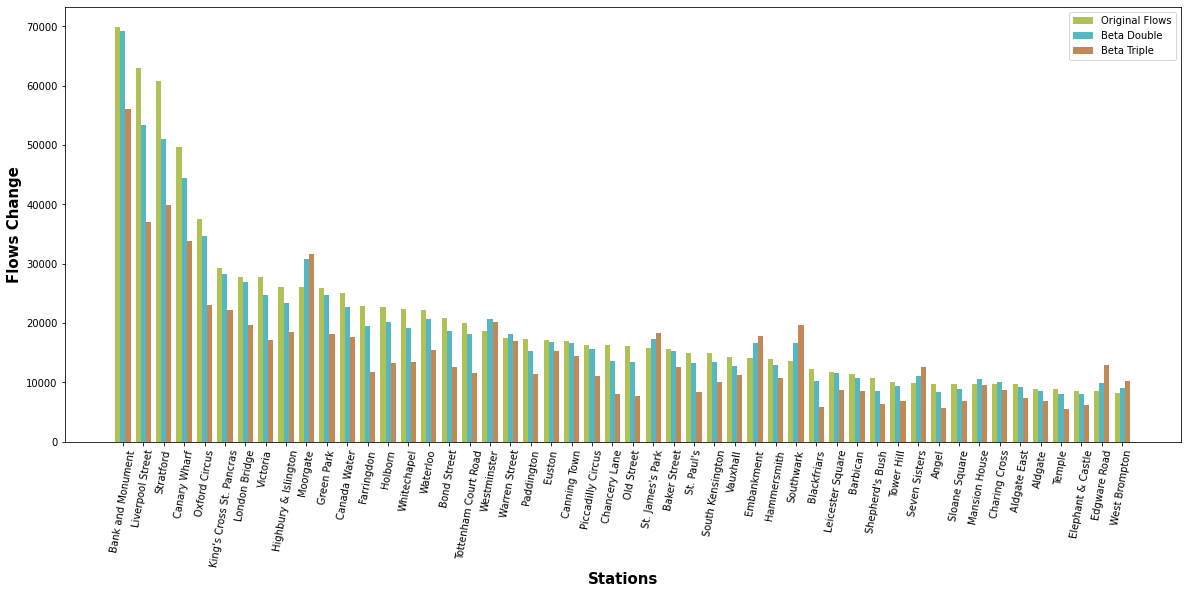

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20,8))
 
# set height of bar
Orig = diff_pdb_50['prodsimest1']
beta_double = diff_pdb_50['prodsimest5']
beta_triple = diff_pdb_50['prodsimest6']
 
# Set position of bar on X axis
br1 = np.arange(len(Orig))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Orig, color ='#b0c255', width = barWidth,
        label ='Original Flows')
plt.bar(br2, beta_double, color ='#55b7c2', width = barWidth,
         label ='Beta Double')
plt.bar(br3, beta_triple, color ='#c28855', width = barWidth,
         label ='Beta Triple')
 
# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=80)
plt.ylabel('Flows Change', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Orig))],
        diff_pdb_50['station_destination'])
 
plt.legend()

In [ ]:
#plot for the SA
diff_pdo = cdata.groupby('station_origin',as_index=False).agg({'prodsimest1':'sum','prodsimest5':'sum','prodsimest6':'sum'})
diff_pdo.sort_values(by=["prodsimest1"],ascending= False, inplace = True)

diff_pdo["diff_abs1"]= abs(diff_pdo["prodsimest5"] - diff_pdo["prodsimest1"])
diff_pdo["diff_abs2"]= abs(diff_pdo["prodsimest6"] - diff_pdo["prodsimest1"])
diff_pdo["diff_1"]= diff_pdo["prodsimest5"] - diff_pdo["prodsimest1"]
diff_pdo["diff_2"]= diff_pdo["prodsimest6"] - diff_pdo["prodsimest1"]
diff_pdo.sort_values(by=["diff_abs2"],ascending= False, inplace = True)


#diff_pdb
diff_pdo_50 = diff_pdo.head(50)
diff_pdo_50

,station_origin,prodsimest1,prodsimest5,prodsimest6,diff_abs1,diff_abs2,diff_1,diff_2
197,King's Cross St. Pancras,28312.0,28308.0,28290.0,4.0,22.0,-4.0,-22.0
55,Canning Town,21135.0,21120.0,21114.0,15.0,21.0,-15.0,-21.0
261,Plaistow,3639.0,3632.0,3622.0,7.0,17.0,-7.0,-17.0
251,Oxford Circus,2788.0,2778.0,2771.0,10.0,17.0,-10.0,-17.0
116,Euston,17794.0,17799.0,17777.0,5.0,17.0,5.0,-17.0
99,Earl's Court,8421.0,8421.0,8405.0,0.0,16.0,0.0,-16.0
4,Aldgate East,3176.0,3173.0,3160.0,3.0,16.0,-3.0,-16.0
213,London Bridge,32597.0,32591.0,32582.0,6.0,15.0,-6.0,-15.0
300,South Ealing,2180.0,2175.0,2165.0,5.0,15.0,-5.0,-15.0
218,Manor House,5461.0,5464.0,5447.0,3.0,14.0,3.0,-14.0


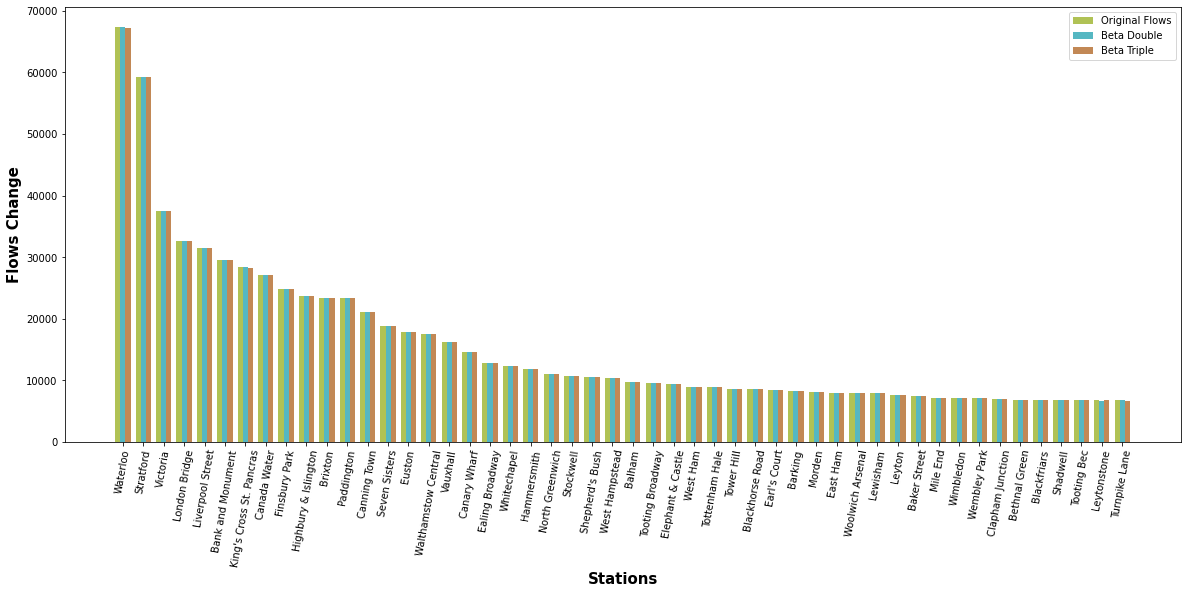

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20,8))
 
# set height of bar
Orig = diff_pdo_50['prodsimest1']
beta_double = diff_pdo_50['prodsimest5']
beta_triple = diff_pdo_50['prodsimest6']
 
# Set position of bar on X axis
br1 = np.arange(len(Orig))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Orig, color ='#b0c255', width = barWidth,
        label ='Original Flows')
plt.bar(br2, beta_double, color ='#55b7c2', width = barWidth,
         label ='Beta Double')
plt.bar(br3, beta_triple, color ='#c28855', width = barWidth,
         label ='Beta Triple')
 
# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=80)
plt.ylabel('Flows Change', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Orig))],
        diff_pdo_50['station_origin'])
 
plt.legend()

## compare a and b

In [185]:
cp = cdata.groupby('station_destination',as_index=False).agg({'prodsimest1':'sum','prodsimest4':'sum','prodsimest5':'sum','prodsimest6':'sum'})
cp.sort_values(by=["prodsimest1"],ascending= False, inplace = True)

In [186]:
cp['p_41'] = cp['prodsimest4']/cp['prodsimest1']
cp['p_51'] = cp['prodsimest5']/cp['prodsimest1']
cp['p_61'] = cp['prodsimest6']/cp['prodsimest1']
cp['s_41'] = cp['prodsimest4'] - cp['prodsimest1']
cp['s_51'] = cp['prodsimest5']-cp['prodsimest1']
cp['s_61'] = cp['prodsimest6']-cp['prodsimest1']
cp.reset_index(inplace=True)

In [193]:
cp.sort_values(by=["s_51"],ascending= True, inplace = True)
cp

,index,station_destination,prodsimest1,prodsimest4,prodsimest5,prodsimest6,p_41,p_51,p_61,s_41,s_51,s_61
2,326,Stratford,60765.0,61950.0,51002.0,39891.0,1.019501,0.839332,0.656480,1185.0,-9763.0,-20874.0
1,212,Liverpool Street,62919.0,63362.0,53411.0,37044.0,1.007041,0.848885,0.588757,443.0,-9508.0,-25875.0
3,54,Canary Wharf,49645.0,31421.0,44421.0,33773.0,0.632914,0.894773,0.680290,-18224.0,-5224.0,-15872.0
12,119,Farringdon,22893.0,23110.0,19443.0,11779.0,1.009479,0.849299,0.514524,217.0,-3450.0,-11114.0
14,386,Whitechapel,22307.0,22517.0,19066.0,13467.0,1.009414,0.854709,0.603712,210.0,-3241.0,-8840.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68,374,West Ham,6212.0,6333.0,9028.0,12053.0,1.019478,1.453316,1.940277,121.0,2816.0,5841.0
33,313,Southwark,13562.0,13690.0,16582.0,19655.0,1.009438,1.222681,1.449270,128.0,3020.0,6093.0
81,163,Heron Quays,4403.0,4711.0,8588.0,12254.0,1.069952,1.950488,2.783102,308.0,4185.0,7851.0
195,327,Stratford High Street,1071.0,1103.0,5479.0,20125.0,1.029879,5.115780,18.790850,32.0,4408.0,19054.0


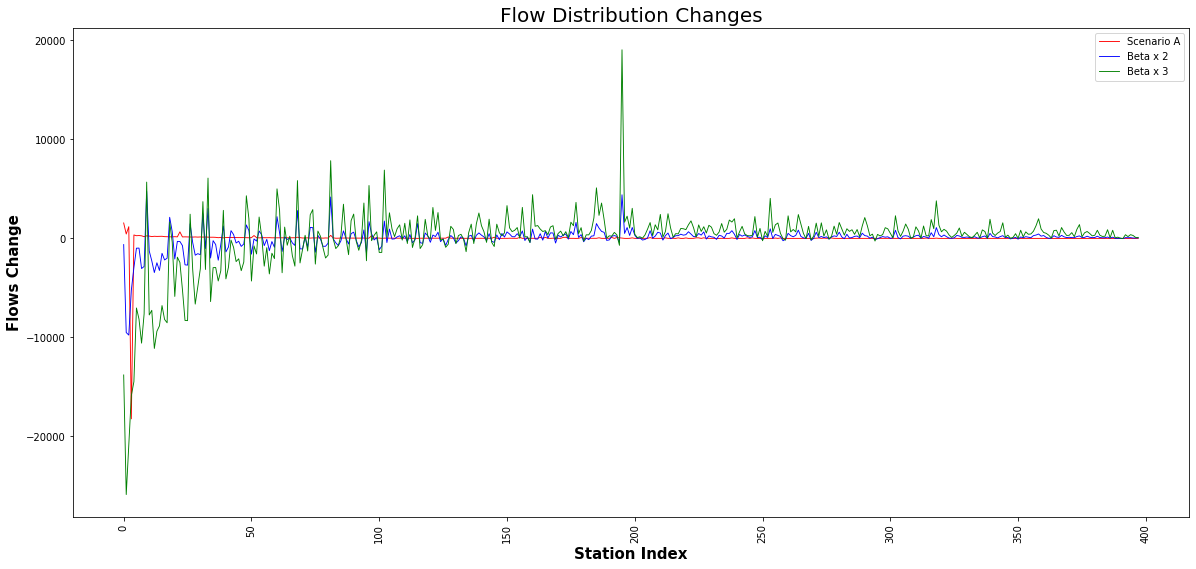

<Figure size 432x288 with 0 Axes>

In [178]:
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = cp.index
y = cp['s_41']
z = cp['s_51']
a = cp['s_61']

# plot line
plt.figure(figsize = (20,9))
plt.xticks(rotation=90)
plt.ylabel('Flows Change', fontweight ='bold', fontsize = 15)
plt.xlabel('Station Index', fontweight ='bold', fontsize = 15)
plt.title('Flow Distribution Changes', fontsize=20)
plt.plot(x, y, color='r',linewidth=0.9, label= 'Scenario A' )
plt.plot(x, z, color='b',linewidth=0.9, label = 'Beta x 2')
plt.plot(x, a, color='g',linewidth=0.9, label = 'Beta x 3')

# ax = plt.gca()
# ax.axes.xaxis.set_ticks([])

plt.legend()
plt.show()
plt.savefig('changes_des')

In [153]:
# import matplotlib.pyplot as plt
# import numpy as np

# x = cp['prodsimest1']
# y = cp['s_41']
# z = cp['s_51']
# a = cp['s_61']

# plt.scatter(x, y, color='red')
# plt.scatter(x, z, color = 'blue')
# plt.scatter(x, a, color='green')
# plt.show()

# double constrained

## **Beta = 1.694**

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'flows ~ station_destination + station_origin + log_distance-1'
#run a doubly constrained sim
doubSim = smf.glm(formula = dbl_form, data=cdata, family=sm.families.Poisson()).fit()
cdata["doubsimest"] = np.round(doubSim.predict()) 

R2_dp = CalcRSqaured(cdata["flows"], cdata["doubsimest"])
RMSE_dp = CalcRMSE(cdata["flows"], cdata["doubsimest"])
beta_dp = doubSim.params[-1]

print('beta:' + str(beta_dp))
print('R2:' + str(R2_dp))

beta:-0.8473602005706751
R2:0.41893772760573444


In [ ]:
#get the estimates
cdata["doubsimfitted"] = np.round(doubSim.mu)
#here's the matrix
cdatasubmat7 = cdata.pivot_table(values ="doubsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,596.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,17.0,16.0,NaN,14.0,NaN,NaN,18.0,...,38.0,4.0,6.0,14.0,NaN,NaN,NaN,NaN,NaN,3745.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,2893.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,...,12.0,NaN,NaN,3.0,NaN,2.0,NaN,2.0,NaN,3178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,8.0,32.0,34.0,NaN,NaN,NaN,NaN,28.0,...,35.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,6.0,19.0,18.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3088.0


In [ ]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [ ]:
# Use the beta we got from the inverse power model
beta = -doubSim.params[-1]
# Get the balancing factors.
cdata = balance_doubly_constrained(cdata,'station_origin','station_destination','O_i','D_j','distance',-beta,'power')
#cdatasub
# Now predict the model again using the new Ai and Dj fields.
cdata['SIM_est_pow'] = np.round(cdata['O_i'] * cdata['Ai_new'] * cdata['D_j'] * cdata['Bj_new'] * 
                                   np.exp(np.log(cdata['distance'])*-beta))
# Check out the matrix
pd.pivot_table(cdata,values='SIM_est_pow',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,596.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1223.0
Acton Town,0,0,0,17,16,0,14,0,0,18,...,38,4,6,14,0,0,0,0,0,3745.0
Aldgate,0,0,0,0,0,0,0,0,0,22,...,0,0,3,3,0,0,0,0,0,2893.0
Aldgate East,0,0,3,0,0,0,0,0,0,22,...,12,0,0,3,0,2,0,2,0,3178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,8,32,34,0,0,0,0,28,...,35,0,10,0,0,0,0,0,0,4862.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,531.0
Woodside Park,0,0,6,19,18,0,0,0,0,22,...,0,0,0,0,0,0,0,0,0,3088.0


In [ ]:
beta

0.8473602005706751

In [ ]:
# Use the beta we got from the inverse power model
beta1 = beta*2
# Get the balancing factors.
cdata = balance_doubly_constrained(cdata,'station_origin','station_destination','O_i','D_j','distance',-beta1,'power')
#cdatasub
# Now predict the model again using the new Ai and Dj fields.
cdata['SIM_est_pow1'] = np.round(cdata['O_i'] * cdata['Ai_new'] * cdata['D_j'] * cdata['Bj_new'] * 
                                   np.exp(np.log(cdata['distance'])*-beta1))
# Check out the matrix
pd.pivot_table(cdata,values='SIM_est_pow1',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224.0
Acton Town,0,0,0,9,9,0,21,0,0,12,...,38,2,2,15,0,0,0,0,0,3756.0
Aldgate,0,0,0,0,0,0,0,0,0,15,...,0,0,1,0,0,0,0,0,0,2879.0
Aldgate East,0,0,0,0,0,0,0,0,0,17,...,3,0,0,1,0,0,0,0,0,3171.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,4,32,36,0,0,0,0,29,...,31,0,6,0,0,0,0,0,0,4863.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,529.0
Woodside Park,0,0,3,15,14,0,0,0,0,23,...,0,0,0,0,0,0,0,0,0,3087.0


## **Beta = 2.541**

In [ ]:
# Use the beta we got from the inverse power model
beta2 = beta*3
# Get the balancing factors.
cdata = balance_doubly_constrained(cdata,'station_origin','station_destination','O_i','D_j','distance',-beta2,'power')
#cdatasub
# Now predict the model again using the new Ai and Dj fields.
cdata['SIM_est_pow2'] = np.round(cdata['O_i'] * cdata['Ai_new'] * cdata['D_j'] * cdata['Bj_new'] * 
                                   np.exp(np.log(cdata['distance'])*-beta2))
# Check out the matrix
pd.pivot_table(cdata,values='SIM_est_pow2',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,594.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1222.0
Acton Town,0,0,0,5,5,0,12,0,0,8,...,25,0,0,10,0,0,0,0,0,3739.0
Aldgate,0,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,2884.0
Aldgate East,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,1,36,42,0,0,0,0,33,...,21,0,1,0,0,0,0,0,0,4867.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,529.0
Woodside Park,0,0,1,13,12,0,0,0,0,27,...,0,0,0,0,0,0,0,0,0,3093.0


In [ ]:
#plot for the SA
diff_dub_des = cdata.groupby('station_destination',as_index=False).agg({'SIM_est_pow':'sum','SIM_est_pow1':'sum','SIM_est_pow2':'sum'})
diff_dub_des.sort_values(by=["SIM_est_pow"],ascending= False, inplace = True)
diff_dub_des = diff_dub_des.reset_index()
diff_dub_des

,index,station_destination,SIM_est_pow,SIM_est_pow1,SIM_est_pow2
0,15,Bank and Monument,78552.0,78544.0,78543.0
1,212,Liverpool Street,61111.0,61123.0,61122.0
2,54,Canary Wharf,58772.0,58774.0,58775.0
3,326,Stratford,55953.0,55950.0,55955.0
4,251,Oxford Circus,44371.0,44368.0,44365.0
...,...,...,...,...,...
393,156,Hatch End,92.0,93.0,92.0
394,22,Beckton Park,88.0,88.0,87.0
395,279,Roding Valley,86.0,85.0,83.0
396,136,Grange Hill,74.0,74.0,75.0


In [ ]:
diff_dub_des['diff_1'] = diff_dub_des['SIM_est_pow1'] - diff_dub_des['SIM_est_pow']
diff_dub_des['diff_2'] = diff_dub_des['SIM_est_pow2'] - diff_dub_des['SIM_est_pow']
diff_dub_des['diff_1_abs'] = abs(diff_dub_des['SIM_est_pow1'] - diff_dub_des['SIM_est_pow'])
diff_dub_des['diff_2_abs'] = abs(diff_dub_des['SIM_est_pow2'] - diff_dub_des['SIM_est_pow'])
#diff_dub_des.sort_values(by=["diff_2_abs"],ascending= False, inplace = True)
diff_dub_des_50 = diff_dub_des.head(50)
diff_dub_des_50

,index,station_destination,SIM_est_pow,SIM_est_pow1,SIM_est_pow2,diff_1,diff_2,diff_1_abs,diff_2_abs
0,15,Bank and Monument,78552.0,78544.0,78543.0,-8.0,-9.0,8.0,9.0
1,212,Liverpool Street,61111.0,61123.0,61122.0,12.0,11.0,12.0,11.0
2,54,Canary Wharf,58772.0,58774.0,58775.0,2.0,3.0,2.0,3.0
3,326,Stratford,55953.0,55950.0,55955.0,-3.0,2.0,3.0,2.0
4,251,Oxford Circus,44371.0,44368.0,44365.0,-3.0,-6.0,3.0,6.0
5,197,King's Cross St. Pancras,33330.0,33331.0,33323.0,1.0,-7.0,1.0,7.0
6,355,Victoria,33245.0,33250.0,33258.0,5.0,13.0,5.0,13.0
7,213,London Bridge,29931.0,29944.0,29927.0,13.0,-4.0,13.0,4.0
8,138,Green Park,26761.0,26764.0,26749.0,3.0,-12.0,3.0,12.0
9,119,Farringdon,25586.0,25588.0,25596.0,2.0,10.0,2.0,10.0


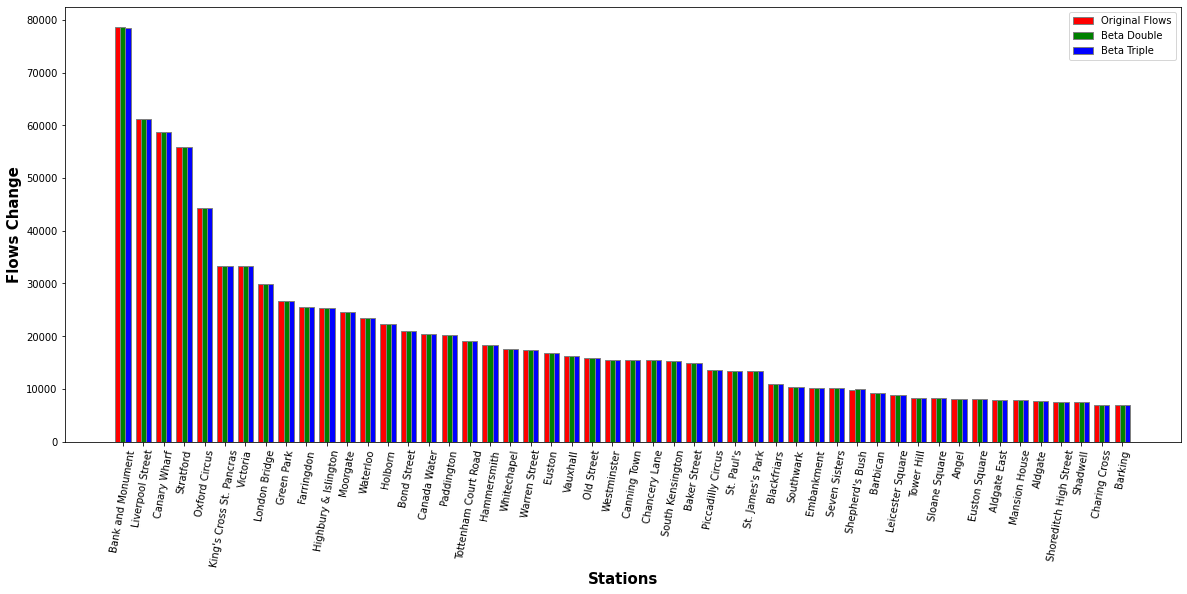

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20,8))
 
# set height of bar
Orig = diff_dub_des_50['SIM_est_pow']
beta_double = diff_dub_des_50['SIM_est_pow1']
beta_triple = diff_dub_des_50['SIM_est_pow2']
 
# Set position of bar on X axis
br1 = np.arange(len(Orig))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Orig, color ='r', width = barWidth,
        edgecolor ='grey', label ='Original Flows')
plt.bar(br2, beta_double, color ='g', width = barWidth,
        edgecolor ='grey', label ='Beta Double')
plt.bar(br3, beta_triple, color ='b', width = barWidth,
        edgecolor ='grey', label ='Beta Triple')
 
# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=80)
plt.ylabel('Flows Change', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Orig))],
        diff_dub_des_50['station_destination'])
 
plt.legend()

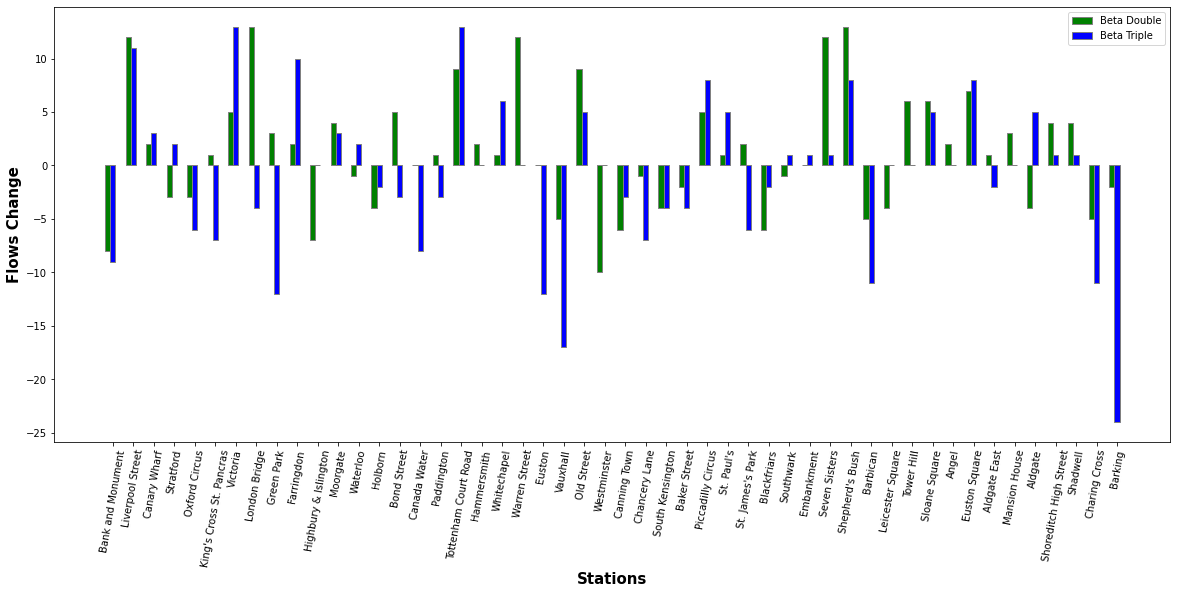

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20,8))
 
# set height of bar
#Orig = diff_dub_des_50['SIM_est_pow']
beta_double = diff_dub_des_50['diff_1']
beta_triple = diff_dub_des_50['diff_2']
 
# Set position of bar on X axis
br1 = np.arange(len(beta_double))
br2 = [x + barWidth for x in br1]
#br3 = [x + barWidth for x in br2]
 
# Make the plot
#plt.bar(br1, Orig, color ='r', width = barWidth,
        #edgecolor ='grey', label ='Original Flows')
plt.bar(br1, beta_double, color ='g', width = barWidth,
        edgecolor ='grey', label ='Beta Double')
plt.bar(br2, beta_triple, color ='b', width = barWidth,
        edgecolor ='grey', label ='Beta Triple')
 
# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=80)
plt.ylabel('Flows Change', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Orig))],
        diff_dub_des_50['station_destination'])
 
plt.legend()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
 
# # create data
# x = diff_dub_des.index
# y = diff_dub_des['SIM_est_pow']
# z = diff_dub_des['SIM_est_pow1']
# a = diff_dub_des['SIM_est_pow2']

# # plot line
# plt.figure(figsize = (20,10))
# plt.xticks(rotation=80)
# plt.ylabel('Flow Changes')
# plt.title('Flow distribution changes', fontsize=20)
# plt.plot(x, y, color='r',linewidth=0.9)
# plt.plot(x, z, color='b',linewidth=0.9)
# plt.plot(x, a, color='g',linewidth=0.9)
# plt.show()
# plt.savefig('changes_des')

In [ ]:
diff_dub_ori = cdata.groupby('station_origin',as_index=False).agg({'SIM_est_pow':'sum','SIM_est_pow1':'sum','SIM_est_pow2':'sum'})
diff_dub_ori.sort_values(by=["SIM_est_pow"],ascending= False, inplace = True)
diff_dub_ori = diff_dub_ori.reset_index()
diff_dub_ori

,index,station_origin,SIM_est_pow,SIM_est_pow1,SIM_est_pow2
0,364,Waterloo,67319.0,67308.0,67308.0
1,326,Stratford,59320.0,59315.0,59301.0
2,355,Victoria,37512.0,37515.0,37512.0
3,213,London Bridge,32585.0,32595.0,32573.0
4,212,Liverpool Street,31476.0,31471.0,31461.0
...,...,...,...,...,...
393,292,Shenfield,248.0,248.0,248.0
394,301,South Hampstead,245.0,250.0,246.0
395,47,Bushey,239.0,241.0,237.0
396,66,Cheshunt,171.0,171.0,170.0


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
 
# # create data
# x = diff_dub_ori.index
# y = diff_dub_ori['SIM_est_pow']
# z = diff_dub_ori['SIM_est_pow1']
# a = diff_dub_ori['SIM_est_pow2']

# # plot line
# plt.figure(figsize = (20,10))
# plt.xticks(rotation=80)
# plt.ylabel('Flow Changes')
# plt.title('Flow distribution changes', fontsize=20)
# plt.plot(x, y, color='r')
# plt.plot(x, z, color='b')
# plt.plot(x, a, color='g')
# plt.show()
# plt.savefig('changes_ori')